# Color Image Quantization
Reduce the number of colors in images (`lena.png`, `peppers.tif`) to 16 using K-means clustering, implemented from scratch. Log L2 norms per iteration and optionally visualize quantized images.

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def kmeans_quantization(image, k=16, max_iterations=100, use_kmeans_plus_plus=True):
    """Perform K-means color quantization on an image, with optional K-means++ initialization."""
    
    pixels = image.reshape(-1, 3)
    
    if use_kmeans_plus_plus:
        print("Using K-means++ initialization...")
        centroids = [pixels[np.random.randint(pixels.shape[0])]]
        for _ in range(1, k):
            dist_sq = np.min([np.linalg.norm(pixels - c, axis=1)**2 for c in centroids], axis=0)
            probs = dist_sq / np.sum(dist_sq)
            cumulative_probs = np.cumsum(probs)
            r = np.random.rand()
            for j, p in enumerate(cumulative_probs):
                if r < p:
                    centroids.append(pixels[j])
                    break
        centroids = np.array(centroids)
    else:
        print("Using random initialization...")
        centroids = pixels[np.random.choice(pixels.shape[0], k, replace=False)]

    l2_norms = []
    for i in range(max_iterations):
        distances = np.linalg.norm(pixels[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.array([pixels[labels == j].mean(axis=0) for j in range(k)])
        

        for j in range(k):
            if np.isnan(new_centroids[j]).any():
                new_centroids[j] = centroids[j]

        quantized_pixels = new_centroids[labels]
        l2_norm_iter = np.sqrt(np.sum((pixels - quantized_pixels)**2))
        l2_norms.append(l2_norm_iter)

        if np.allclose(centroids, new_centroids):
            print(f"Convergence reached at iteration {i+1}.")
            break
        
        centroids = new_centroids

    quantized_image = centroids[labels].reshape(image.shape)
    
    return quantized_image, l2_norms

In [26]:
def calculate_l2_norm(original, quantized):
    """Calculate total L2 norm between original and quantized images.
    
    Args:
        original: Original image (H, W, 3) as float32 in [0, 1].
        quantized: Quantized image (H, W, 3) as float32 in [0, 1].
    
    Returns:
        l2_norm: Total L2 norm across all pixels.
    """
    return np.sqrt(np.sum((original - quantized)**2))

In [27]:
lena_path = './lena.png' 
peppers_path = './peppers.tif' 

try:
    lena = cv2.imread(lena_path).astype(np.float32) / 255.0
    peppers = cv2.imread(peppers_path).astype(np.float32) / 255.0

    if lena is None or peppers is None:
        raise Exception("One of the images could not be loaded. Check paths and file integrity.")
    print("Both images loaded successfully!")
    
except Exception as e:
    print(f"Error loading images: {e}. Using random placeholder images.")
    lena = np.random.rand(512, 512, 3).astype(np.float32)
    peppers = np.random.rand(384, 512, 3).astype(np.float32)

k = 16
max_iterations = 100
visualize = False

Both images loaded successfully!


Processing Lena...
Using random initialization...

Processing Peppers...
Using random initialization...
Convergence reached at iteration 65.


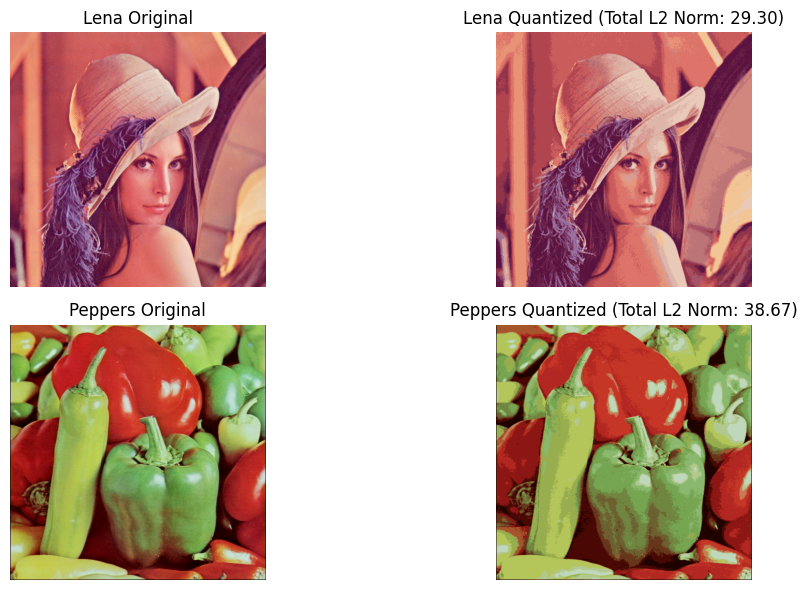

Quantized images and L2 norm log have been saved successfully.


In [28]:
print("Processing Lena...")
lena_quantized, lena_l2_norms = kmeans_quantization(lena, k, max_iterations, visualize)
print("\nProcessing Peppers...")
peppers_quantized, peppers_l2_norms = kmeans_quantization(peppers, k, max_iterations, visualize)


with open('L2_norm_log.txt', 'w') as f:
    f.write('Lena L2 Norms per iteration:\n' + '\n'.join(map(str, lena_l2_norms)) + '\n\n')
    f.write('Peppers L2 Norms per iteration:\n' + '\n'.join(map(str, peppers_l2_norms)) + '\n')


final_lena_l2 = calculate_l2_norm(lena, lena_quantized)
final_peppers_l2 = calculate_l2_norm(peppers, peppers_quantized)


plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(lena, cv2.COLOR_BGR2RGB))
plt.title('Lena Original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(lena_quantized, cv2.COLOR_BGR2RGB))
plt.title(f'Lena Quantized (Total L2 Norm: {final_lena_l2:.2f})')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(peppers, cv2.COLOR_BGR2RGB))
plt.title('Peppers Original')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(peppers_quantized, cv2.COLOR_BGR2RGB))
plt.title(f'Peppers Quantized (Total L2 Norm: {final_peppers_l2:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()


cv2.imwrite('lena_quantized.png', (lena_quantized * 255).astype(np.uint8))
cv2.imwrite('peppers_quantized.png', (peppers_quantized * 255).astype(np.uint8))

print("Quantized images and L2 norm log have been saved successfully.")